# Solving the Quantum Linear Systems Problem (QLSP) using AQC - Part 1

## Overview

Adiabatic Quantum Computing (AQC) uses the adiabatic theorem to solve problems by evolving a quantum system from an initial ground state to the ground state of a problem Hamiltonian. In this tutorial, we'll demonstrate how AQC can solve a Quantum Linear Systems Problem (QLSP) [[1](#QLSP)], a foundational problem in quantum computing with applications in machine learning, physics, and optimization. 


## 1. Adiabatic Quantum Computing and the Adiabatic Theorem

The adiabatic theorem states that a quantum system initialized in the ground state of a Hamiltonian will remain in the ground state if the Hamiltonian evolves slowly enough. AQC utilizes this principle to encode problems into Hamiltonians.


### **Key components for AQC**

1. **Initial Hamiltonian** $H_{0}$ : Represents a simple problem whose ground state can be easily prepared.
2. **Final Hamiltonian** $H_f$: Encodes the problem of interest.
3. **Interpolated Hamiltonian** $H(t)$:
    \begin{equation}
    H(t) = (1 - s(t))H_{0}+s(t) H_f ,
    \end{equation}

   where $s(t)$ represents a scheduling function that interpolates from $0$ to $1$ over time $T$.

   *A simple linear scheduling function used for "vanilla AQC" use case: $s(t) = t / T$*



### **Time evolution**
   
   The system evolves according to the time-dependent Schrödinger equation:

\begin{equation}
    i \hbar \frac{\partial}{\partial t} |\psi(t)\rangle = H(t) |\psi(t)\rangle ,
\end{equation}

\begin{equation}
    \psi(t)\ = e^{-itH(t)}\psi(0)\,
\end{equation}


**The **Adiabatic Path****:
   *Slowly* evolving the system from $H_0$ to $H_f$ over time $T$.
    
    
* *The adiabatic path in Adiabatic Quantum Computing (AQC) must be implemented slowly enough to satisfy the adiabatic condition. This ensures the system remains in its instantaneous ground state throughout the evolution. The rate of change depends on the properties of the Hamiltonians and the energy gap between the ground state and the first excited state.*


-------

### **Simple Example: Evolving from Pauli-Z to Pauli-X**

In this example, we evolve a system from the ground state of the Pauli-Z Hamiltonian (the $|1\rangle$ state) to the ground state of the Pauli-X Hamiltonian (the $\ket{-}$ state). We will use the "vanilla AQC" linear scheduling function $s(t)$.




#### Setting up the AQC system: 

In [1]:
import numpy as np

# Pauli X as H0
H0 = np.array([[1, 0], [0, -1]])  # Ground state |1>

# Pauli X as Hf (problem Hamiltonian, for example)
Hf = np.array([[0, 1], [1, 0]])  

# Define the time-dependent Interpolated Hamiltonian, where T is the total evolution time
def hamiltonian_t(H0, Hf, t, T):
    return (1 - t/T) * H0 + (t/T) * Hf


TOTAL_EVOUTION_TIME = 10  # The total evolution time - T
NUM_STEPS = 100  # Defines the velocity of the adiabatic path implementation - the bigger it is the slower the path 

####  **Classical AQC Implementation:**

Lets first simulate the adiabatic path evolution using classical code. 
The final state of the system is expected to be the $\ket{-}$ state.

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# Define a time evolution function that follows the adiabatic path
def classical_adiabatic_evolution(H0, Hf, T, num_steps, initial_state):
    # Time step for each increment
    delta_t = T / num_steps
    psi = initial_state
    # Iterate over time steps
    for step in range(num_steps):
        t = step * delta_t
        # Compute the instantaneous Hamiltonian H(t)
        H_t = hamiltonian_t(H0, Hf, t, T)
        
        # Use the exponential of the Hamiltonian to evolve the system
        U_t = linalg.expm(-1j * H_t * delta_t)
        
        # Evolve the state psi
        psi = U_t @ psi
        
    return psi

# Start with the ground state of H0
eigvals, eigvecs = np.linalg.eigh(H0)
initial_state = eigvecs[:, 0]  # Ground state of H0
# Run the adiabatic evolution
final_state = classical_adiabatic_evolution(H0, Hf, TOTAL_EVOUTION_TIME, NUM_STEPS, initial_state)

# Print the final state vector
print("Final state:", final_state)


Final state: [ 0.24874567-0.66989512j -0.17506289+0.67728805j]


**Comparing Results:**

In [3]:
def plot_state_probabilities(title, x , color='b'):
    # Ensure x is a numpy array and normalized
    x = np.array(x)
    
    # Calculate probabilities
    probabilities = np.abs(x) ** 2
    
    # Create labels for the states
    labels = [f'|{i}>' for i in range(len(x))]
    
    # Plot the probabilities
    plt.bar(labels, probabilities, color=color, alpha=0.7)
    plt.xlabel('Quantum States')
    plt.ylabel('Probabilities')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()

def phase_difference(v1, v2):
    # Ensure vectors are complex
    v1 = np.array(v1, dtype=np.complex128)
    v2 = np.array(v2, dtype=np.complex128)
    
    # Compute the inner product and find its angle (phase difference)
    inner_product = np.vdot(v1, v2)  # Computes conjugate transpose of v1 * v2
    phase_diff = np.angle(inner_product)  # Angle of the inner product in radians
    
    return phase_diff

def compare_states(state1, state1_label, state2, state1_labe2):
    # Plot a histogram of each state probabilities
    plot_state_probabilities(state1_label ,state1, 'g')
    plot_state_probabilities(state1_labe2,state2)
    
    # Check the overlap between states
    overlap = np.abs(np.vdot(state1, state2))**2
    print(f"Similarity of results: {overlap:.4f}")
    # Calculate phase difference
    phase_diff = phase_difference(state1, state2)
    print(f"Phase difference: {np.degrees(phase_diff)} degrees")




Expected ground state for Hf:
[-0.70710678  0.70710678]
Comparing the final state with the expected solution:


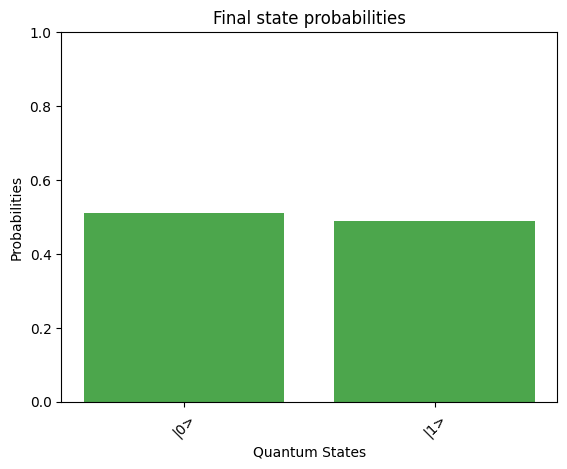

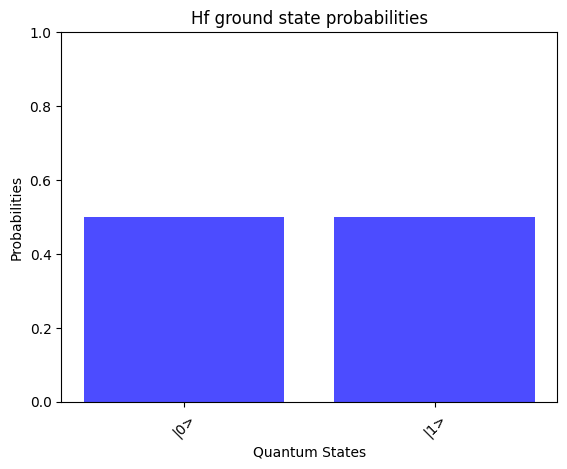

Similarity of results: 0.9973
Phase difference: -107.4629845829176 degrees


In [4]:
# Verify if the system remains in the ground state of Hf

# Ground state of Hf:
print("Expected ground state for Hf:")
eigvals_f, eigvecs_f = np.linalg.eigh(Hf)
ground_state_Hf = eigvecs_f[:, 0]  # Ground state of Hf
print(ground_state_Hf)


print("Comparing the final state with the expected solution:")
compare_states(final_state,'Final state probabilities', ground_state_Hf,'Hf ground state probabilities')

####  **Quantum AQC Implementation:**

Using the Classiq platform, we simulate the adiabatic path on a quantum simulator with Suzuki-Trotter decomposition for Hamiltonian exponentiation.

In [5]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.qmod.symbolic import pi

We will use the built-in function `matrix_to_hamiltonian` to encode the Hamiltonians as Pauli Operators:

In [6]:
# Hamiltonian matrix to sum of Paulis:
HO_HAMILTONIAN = matrix_to_hamiltonian(H0)
Hf_HAMILTONIAN = matrix_to_hamiltonian(Hf)

**Building a Quantum model:**

In [7]:
@qfunc(generative=True)
def adiabatic_evolution_qfunc(evolution_time: CInt, num_steps: CInt, qba: QArray[QBit]):
    # Time step for each increment
    delta_t = evolution_time / num_steps
    for step in range(num_steps):
        t = step * delta_t
        suzuki_trotter(
        HO_HAMILTONIAN,
        evolution_coefficient=(1 - t/evolution_time),
        order=1,
        repetitions=1,
        qbv=qba,
        )
        suzuki_trotter(
        Hf_HAMILTONIAN,
        evolution_coefficient=(t/evolution_time),
        order=1,
        repetitions=10,
        qbv=qba,
        )
      

@qfunc
def main(qba: Output[QArray[QBit]]):
    prepare_state(probabilities= (np.abs(np.array([0,1]))**2).tolist(), bound=0.01, out=qba) #Preparing the ground state for H0 in the state |1>
    adiabatic_evolution_qfunc(TOTAL_EVOUTION_TIME, NUM_STEPS, qba)


qmod = create_model(main)







**Synthesize the model into a Quantum Program, verify it and execute it on a state vector simulator:**

In [8]:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)

qprog = synthesize(qmod)
show(qprog)
result = execute(qprog).result_value()
result_state_vector = result.state_vector

# Convert dictionary values to complex numbers
state_vector = np.array([complex(value) for value in result_state_vector.values()])

# Print the final state vector
print("Final quantum state after adiabatic evolution implemnted on a quantum simulator:")
print(state_vector)

Opening: https://platform.classiq.io/circuit/ae253695-2ca4-40f6-9dfe-1653c48e87ba?version=0.60.1
Final quantum state after adiabatic evolution implemnted on a quantum simulator:
[ 0.70496673+0.j         -0.70919971+0.00759513j]


**Comparing results:**

Expected ground state for Hf:
[-0.70710678  0.70710678]
Comparing the final quantum state with the expected solution:


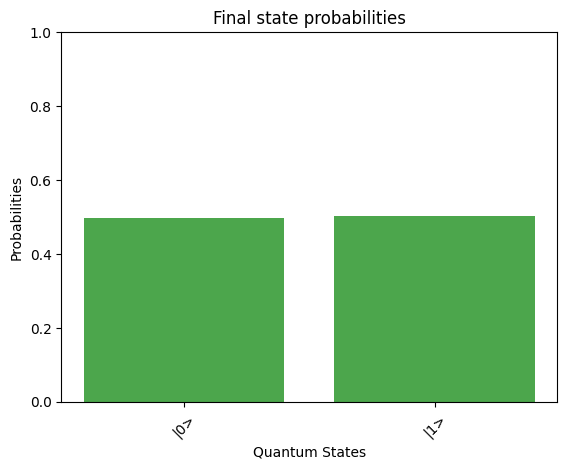

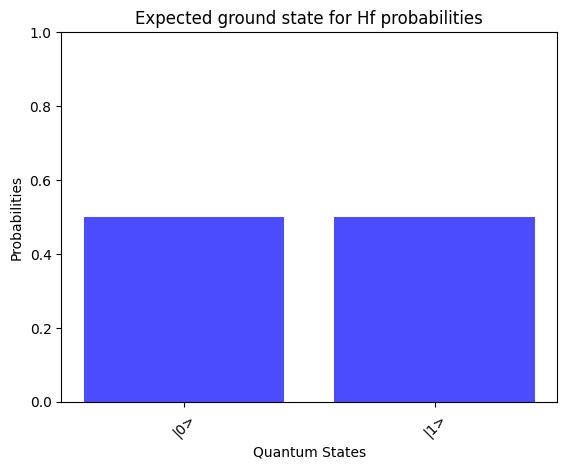

Similarity of results: 1.0000
Phase difference: -179.6922816381405 degrees


In [9]:
# Verify if the system remains in the ground state of Hf

# Ground state of Hf:
print("Expected ground state for Hf:")
eigvals_f, eigvecs_f = np.linalg.eigh(Hf)
ground_state_Hf = eigvecs_f[:, 0]  # Ground state of Hf
print(ground_state_Hf)

print("Comparing the final quantum state with the expected solution:")
compare_states(state_vector,'Final state probabilities', ground_state_Hf,'Expected ground state for Hf probabilities')


**We successfully implemented the expected adiabatic path from Pauli Z ground state to Pauli X ground state!** 


----------

### **Evolving a 4x4 Hamiltonian**
**Now lets try to evolve into the ground state of an Hamiltonian represented by a 4X4 matrix. For the adiabatic path we wull again use  using the "vanila" AQC linear scheduling function $s(t)$.**

#### Setting up the AQC system: 

In [10]:
# Define the initial Hamiltonian H0 (diagonal 4x4 matrix)
H0 = np.diag([1, 2, 3, 4])

# Define the final Hamiltonian Hf (random 4x4 matrix)
Hf = np.array([[0, 1, 0, 0],
               [1, 0, 1, 0],
               [0, 1, 0, 1],
               [0, 0, 1, 0]])
 
# Define the time-dependent Interpolated Hamiltonian, where T is the total evolution time
def hamiltonian_t(H0, Hf, t, T):
    return (1 - t/T) * H0 + (t/T) * Hf


TOTAL_EVOUTION_TIME = 10  # The total evolution time - T
NUM_STEPS = 100  # Defines the velocity of the adiabatic path implementation - the bigger it is the slower the path 

####  **Classical AQC Implementation:** 

In [11]:
# Start with the ground state of H0
eigvals, eigvecs = np.linalg.eigh(H0)
initial_state = eigvecs[:, 0]  # Ground state of H0
# Run the adiabatic evolution
final_state = classical_adiabatic_evolution(H0, Hf, TOTAL_EVOUTION_TIME, NUM_STEPS, initial_state)

# Print the final state vector
print("Final quantum state after classicaly implemnting the adiabatic evolution:")
print(final_state)



Final quantum state after classicaly implemnting the adiabatic evolution:
[ 0.40278502+0.10124677j -0.59174735-0.17447169j  0.52899833+0.21834392j
 -0.29518038-0.17961979j]


**Comparing results:**

Expected ground state for Hf:
[ 0.37174803 -0.60150096  0.60150096 -0.37174803]
Comparing the final state with the expected solution:


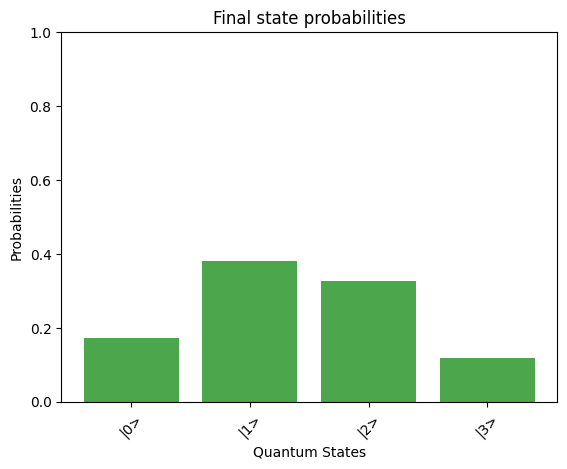

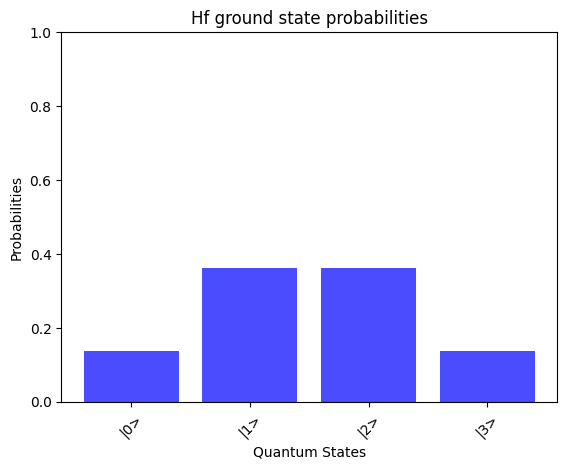

Similarity of results: 0.9877
Phase difference: -20.048166369614027 degrees


In [12]:
# Verify if the system remains in the ground state of Hf

# Ground state of Hf solved mathematically 
print("Expected ground state for Hf:")
eigvals_f, eigvecs_f = np.linalg.eigh(Hf)
ground_state_Hf = eigvecs_f[:, 0]  # Ground state of Hf
print(ground_state_Hf)

print("Comparing the final state with the expected solution:")
compare_states(final_state,'Final state probabilities', ground_state_Hf,'Hf ground state probabilities')

####  **Quantum AQC Implementation:**

Using the Classiq platform (same as described above),we simulate the adiabatic path on a quantum simulator with Suzuki-Trotter decomposition for Hamiltonian exponentiation.

We will use the built-in function `matrix_to_hamiltonian` to encode the Hamiltonians as Pauli Operators:

In [13]:
# Hamiltonian matrix to sum of Paulis:
HO_HAMILTONIAN = matrix_to_hamiltonian(H0)
Hf_HAMILTONIAN = matrix_to_hamiltonian(Hf)

**Building a Quantum model:**

In [14]:
@qfunc
def main(qba: Output[QArray[QBit]]):
    allocate(len(HO_HAMILTONIAN[0].pauli), qba)
    # The ground state for H0 is \0> so there is no need to prepare qba 
    adiabatic_evolution_qfunc(TOTAL_EVOUTION_TIME, NUM_STEPS, qba)

qmod = create_model(main)






**Synthesize the model into a Quantum Program, verify it and execute it on a state vector simulator:**

In [15]:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)


qprog = synthesize(qmod)
show(qprog)
result = execute(qprog).result_value()
result_state_vector = result.state_vector

# Convert dictionary values to complex numbers
state_vector = np.array([complex(value) for value in result_state_vector.values()])

# Print the final state vector
print("Final quantum state after adiabatic evolution implemnted on a quantum simulator:")
print(state_vector)

Opening: https://platform.classiq.io/circuit/4c5ae27a-1f55-4ab7-a210-d7012d48632a?version=0.60.1
Final quantum state after adiabatic evolution implemnted on a quantum simulator:
[ 0.3337263 +0.17793509j -0.54404494-0.2653977j   0.53281431+0.26948468j
 -0.31554335-0.18564572j]


**Comparing results:**

Expected ground state for Hf:
[ 0.37174803 -0.60150096  0.60150096 -0.37174803]
Comparing the final quantum state with the expected solution:


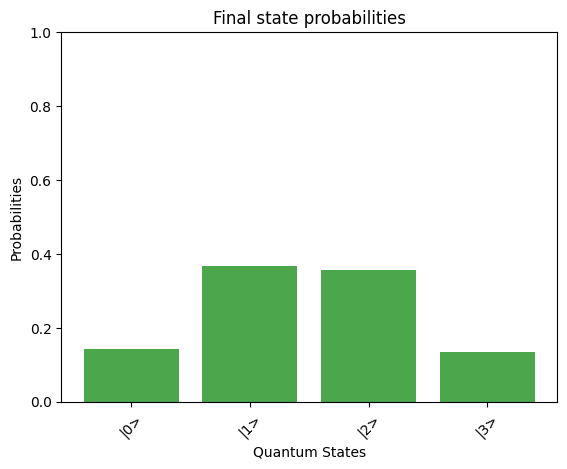

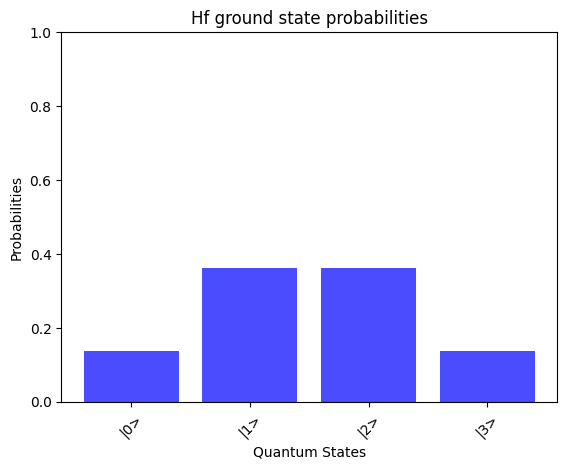

Similarity of results: 0.9992
Phase difference: -27.197916990940744 degrees


In [16]:
# Verify if the system remains in the ground state of Hf

# Ground state of Hf is |+> = (|0> + |1>)/sqrt(2)
print("Expected ground state for Hf:")
eigvals_f, eigvecs_f = np.linalg.eigh(Hf)
ground_state_Hf = eigvecs_f[:, 0]  # Ground state of Hf
print(ground_state_Hf)

print("Comparing the final quantum state with the expected solution:")
compare_states(state_vector,'Final state probabilities', ground_state_Hf,'Hf ground state probabilities')

**The results agree with the expcted numerical results!**
Now that we are comfortable with AQC we can go a head and utilize it to solve a Quantum Linear Systems Problem

----------

## 2. Solving the Quantum Linear Systems Problem (QLSP) using AQC 


Next, we want to solve the **Quantum Linear Systems Problem (QLSP)** using an **adiabatic quantum computation (AQC)** approach. The QLSP involves finding an approximate quantum state corresponding to the solution of a linear system. Below is a structured overview of the problem, the mathematical formulation, and its transformation into an eigenvalue problem (based on [[1](#QLSP)]).


### **1. Problem Statement**

Given a Hermitian positive-definite matrix $A$ and a vector $|b\rangle$, the goal is to approximate 
$|x\rangle$, the solution to the linear system $A|x\rangle=|b\rangle$, as a quantum state.


We are given:
- **Matrix** $A \in \mathbb{C}^{N \times N}$, an invertible Hermitian and positive-definite matrix with condition number $\kappa$ and $\|A\|_2 = 1$.
- **Vector** $|b\rangle \in \mathbb{C}^N$, a normalized vector.
- **Target Error** $\epsilon$, specifying the desired accuracy.

The goal is to prepare a quantum state $|x_a\rangle$, which is an $\epsilon$-approximation of the normalized solution $|x\rangle = A^{-1}|b\rangle / \|A^{-1}|b\rangle\|_2$. The approximation satisfies:

$$
\| |x_a\rangle \langle x_a| - |x\rangle \langle x| \|_2 \leq \epsilon.
$$

---

### **2. Transformation into AQC**

The QLSP is converted into an equivalent eigenvalue problem to leverage quantum computation. This involves the following steps:

#### **2.1 Null Space of $H_0$**
Define:

$$
H_0 = \sigma_x \otimes Q_b = 
\begin{bmatrix}
0 & Q_b \\
Q_b & 0
\end{bmatrix},
$$

where $Q_b = I_N - |b\rangle \langle b|$ is a projection operator orthogonal to $|b\rangle$.

Key properties:
- $H_0$ is Hermitian.
- The null space of $H_0$: $\text{Null}(H_0) = \text{span}(|b\rangle, |\bar{b}\rangle)$, where 

$$
|b\rangle = |0, b\rangle = \begin{bmatrix} b \\ 0 \end{bmatrix}, \quad 
|\bar{b}\rangle = |1, b\rangle = \begin{bmatrix} 0 \\ b \end{bmatrix}.
$$

#### **2.2 Constructing $H_1$**
Define:

$$
H_1 = \sigma_+ \otimes (AQ_b) + \sigma_- \otimes (Q_bA) =
\begin{bmatrix}
0 & AQ_b \\
Q_bA & 0
\end{bmatrix},
$$

where $\sigma_\pm = \frac{1}{2}(\sigma_x \pm i\sigma_y)$.

Key properties:
- If $A|x\rangle \propto |b\rangle$, then $Q_bA|x\rangle = Q_b|b\rangle = 0$.
- Null space of $H_1$: $\text{Null}(H_1) = \text{span}(|x\rangle, |\bar{b}\rangle)$.

#### **2.3 Spectral Gap**
- $Q_b$ is a projection operator, and the spectral gap of $H_0$ is $1$.
- For $H_1$, the gap between $0$ and the rest of the eigenvalues is bounded below by $1/\kappa$.

#### **2.4 Adiabatic Interpolation**
Construct an interpolation Hamiltonian:

$$
H(f(s)) = (1 - f(s))H_0 + f(s)H_1, \quad 0 \leq s \leq 1,
$$

where $f(s)$ is a monotonic function mapping $[0, 1] \to [0, 1]$.

---

### **3. AQC Approach**
The adiabatic quantum algorithm prepares the zero-energy state $|x\rangle$ of $H_1$ as follows:
1. Initialize in the ground state of $H_0$, i.e., $|b\rangle$.
2. Slowly evolve the system by varying $f(s)$ from $f(0) = 0$ to $f(1) = 1$.
3. At the end of the evolution, the system will approximate $|x\rangle$, the solution of the QLSP.

---

### **4. Tutorial Goals**
- **Set up a QLSP example:** Derive $H_0$, $H_1$.
- **Quantum Circuit Design:** Implement Hamiltonian simulation for $H(f(s))$.
- **Evaluate results:** Compare quantum simulation results with the numeric calculation.

---


Let’s begin with the mathematical setup and proceed to implementation!


### **Setting up a QLSP example where A is a 4x4 matrix:**

In [17]:
# Define matrix A and vector b
A = np.array([[4, 1, 2, 0], 
              [1, 3, 0, 1], 
              [2, 0, 3, 1], 
              [0, 1, 1, 2]])
b = np.array([12, 10, 17, 26])


#### Setting up the QLSP:

In [18]:

def setup_QLSP(A,b):
    #Normalize A
    norm_A = np.linalg.norm(A, 'fro')
    A_normalized = A / norm_A

    # Normalize vector b
    b_normalized = b / np.linalg.norm(b)
    
    # Create the outer product of b
    outer_product_b = np.outer(b_normalized, b_normalized)
    
    # Define the identity matrix I with the same size as b
    identity_matrix = np.eye(len(b))
    
    # Compute Qb = I - outer_product_b
    Qb = identity_matrix - outer_product_b
    
    # Define the Pauli-X (σx) and Pauli-Y (σy) matrices
    pauli_x = np.array([[0, 1], 
                        [1, 0]])
    
    pauli_y = np.array([[0, -1j], 
                        [1j, 0]])
    
    # Define Pauli plus and minus operators
    pauli_plus = 0.5 * (pauli_x + 1j * pauli_y)
    pauli_minus = 0.5 * (pauli_x - 1j * pauli_y)
    
    # Compute the tensor product of Pauli-X and Qb
    H0 = np.kron(pauli_x, Qb)
    
    # Compute A*Qb and Qb*A
    A_Qb = np.dot(A, Qb)
    Qb_A = np.dot(Qb, A)
    
    # Compute the tensor products
    tensor_plus = np.kron(pauli_plus, A_Qb)
    tensor_minus = np.kron(pauli_minus, Qb_A)
    
    # Define Hf as the sum of the two tensor products
    Hf = tensor_plus + tensor_minus

    HO_HAMILTONIAN = matrix_to_hamiltonian(H0)
    Hf_HAMILTONIAN = matrix_to_hamiltonian(Hf)

    return H0, Hf, HO_HAMILTONIAN , Hf_HAMILTONIAN, A_normalized, b_normalized


#Setup 

H0, Hf, HO_HAMILTONIAN , Hf_HAMILTONIAN, A_normalized, b_normalized = setup_QLSP(A,b)
TOTAL_EVOUTION_TIME = 10
NUM_STEPS = 100

# Define the time-dependent Interpolated Hamiltonian, where T is the total evolution time
def hamiltonian_t(H0, Hf, t, T):
    return (1 - t/T) * H0 + (t/T) * Hf

#### **Classical AQC implementation:**

In [19]:
# Start with the state |b>
initial_state = np.kron(np.array([1,0]),b_normalized )
# Run the adiabatic evolution
final_state = classical_adiabatic_evolution(H0, Hf, TOTAL_EVOUTION_TIME, NUM_STEPS, initial_state)

# Print the final state vector
print("Final quantum state after classicaly implemnting the adiabatic evolution:")
print(final_state)



Final quantum state after classicaly implemnting the adiabatic evolution:
[ 0.40563797+0.j         -0.16982023+0.j         -0.15298747+0.j
  0.8713242 +0.j          0.        +0.10910979j  0.        -0.04242954j
  0.        -0.09713021j  0.        +0.0294689j ]


#### **Comparing results:**

Solution vector x:
[ 0.32300564 -0.23491319 -0.22423532  0.88893288]


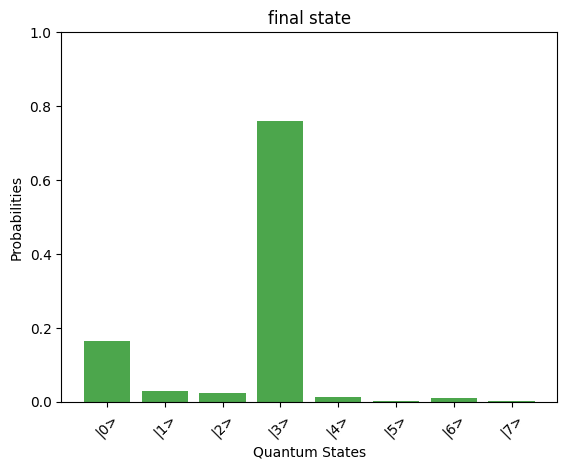

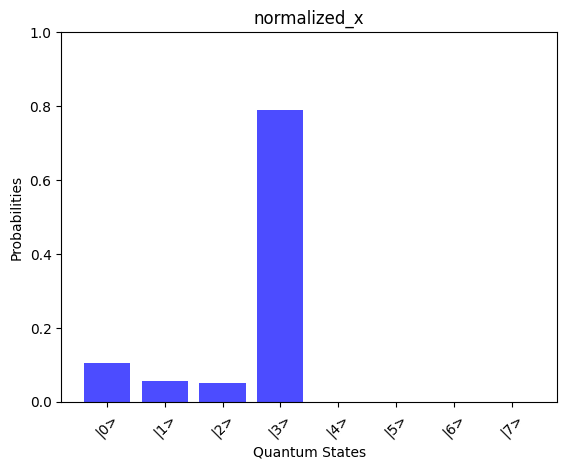

Similarity of results: 0.9599
Phase difference: 0.0 degrees


In [20]:
# Verify if the system solves the linear problem

# Print the solution vector x
# Use np.linalg.solve() to find x
x = np.linalg.solve(A_normalized, b_normalized)
print("Solution vector x:")
normalized_x = x/ np.linalg.norm(x)
print(normalized_x)

compare_states(final_state,'final state', np.kron(np.array([1,0]),normalized_x ),'normalized_x')

### **Quantum AQC Implementation:**

**Building a Quantum model:**

In [21]:
@qfunc
def main(qba: Output[QArray[QBit]]):
    prepare_state(probabilities= (np.abs(np.kron(np.array([1,0]),b_normalized ))**2).tolist(), bound=0.01, out=qba)
    adiabatic_evolution_qfunc(TOTAL_EVOUTION_TIME, NUM_STEPS, qba)


qmod = create_model(main)






**Synthesize the model into a Quantum Program, verify it and execute it on a state vector simulator:** 

In [22]:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)


qprog = synthesize(qmod)
write_qmod(qmod, "solving_vqls_with_aqc")
show(qprog)

result = execute(qprog).result_value()
result_state_vector = result.state_vector

Opening: https://platform.classiq.io/circuit/0b37f72b-fe7a-44f0-a41c-424deac5ef76?version=0.60.1


**Evaluate results:**

Solution vector x:
[ 0.32300564 -0.23491319 -0.22423532  0.88893288]
State vector:
[ 0.17569561+0.2504778j  -0.1220673 -0.17402341j -0.12169957-0.17349916j
  0.51216533+0.7301608j   0.07062183-0.04953711j  0.00675191-0.00473607j
 -0.04419679+0.03100148j  0.08357987-0.05862642j]


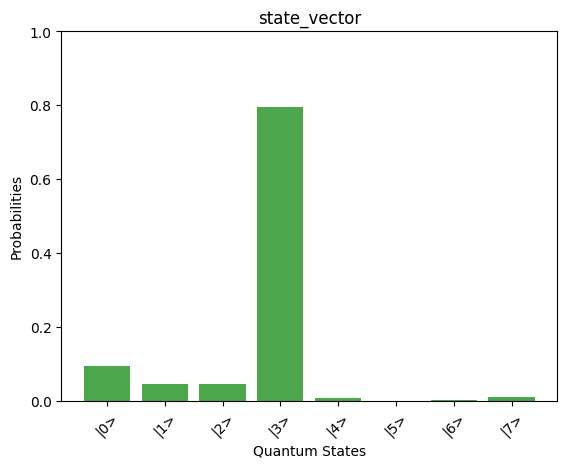

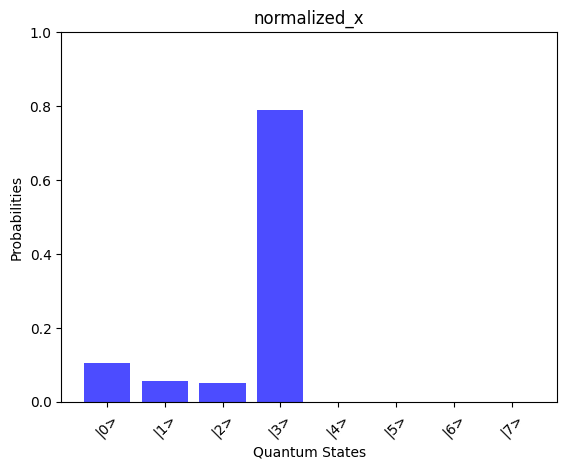

Similarity of results: 0.9783
Phase difference: -54.9525736055916 degrees


In [23]:
# Print the solution vector x
# Use np.linalg.solve() to find x
x = np.linalg.solve(A_normalized, b_normalized)
print("Solution vector x:")
normalized_x = x/ np.linalg.norm(x)
print(normalized_x)

# Convert dictionary values to complex numbers
print("State vector:")
state_vector = np.array([complex(value) for value in result_state_vector.values()])
print(state_vector)

compare_states(state_vector,'state_vector', np.kron(np.array([1,0]),normalized_x ),'normalized_x')

***By comparing the quantum-computed results with the mathematically expected solution, we observe a good alignment - showcasing the potential of the AQC approach for solving linear problems***

<a id='QLSP'>[1]</a>: [An, D. and Lin, L. “Quantum Linear System Solver Based on Time-Optimal Adiabatic Quantum Com- puting and Quantum Approximate Optimization Algorithm.” ACM Trans. Quantum Comput. 3 (2022). arXiv:1909.05500.](https://arxiv.org/abs/1909.05500).


